This notebook is part of the `kikuchipy` documentation https://kikuchipy.org.
Links to the documentation won't work from the notebook.

# Pattern matching

Crystal orientations can be determined from experimental EBSD patterns by
matching them to a dictionary of simulated patterns.

Here, we will demonstrate pattern matching using a small Ni data set of nine
EBSD patterns and a dynamically simulated master pattern from EMsoft, both of
low resolution and found in the [kikuchipy.data](reference.rst#data) module.

<div class="alert alert-warning">

Warning

Two things about the current implementation of pattern matching in kikuchipy
are worth mentioning here: (1) The generation of a pattern dictionary from a
master pattern is considered experimental, with at least
[one issue](https://github.com/pyxem/kikuchipy/issues/254), so must be used with
care, and (2) the generated pattern dictionary is discrete, but no refinement is
provided.

</div>

Before we can generate a dictionary of
simulated patterns, we need a master pattern containing all possible scattering
vectors for a candidate phase. This can be done using EMsoft
<cite data-cite="callahan2013dynamical">Callahan and De Graef (2013)</cite>
<cite data-cite="jackson2014h5ebsd">Jackson et al. (2014)</cite>, and then read
into kikuchipy.

First, we import libraries and load the small experimental Nickel test data

In [2]:
# exchange inline for qt5 for interactive plotting from the pyqt package
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 15
import hyperspy.api as hs
import numpy as np
from orix import sampling, plot
import kikuchipy as kp


s = kp.data.nickel_ebsd_small()  # Use kp.load("data.h5") to load your own data
s

<EBSD, title: patterns My awes0m4 ..., dimensions: (3, 3|60, 60)>

To obtain a good match, we increase the signal-noise-ratio by removing the
diffuse background resulting from the inelastically scattered electrons

In [3]:
s.remove_static_background()
s.remove_dynamic_background()

Removing the static background:
[########################################] | 100% Completed |  0.4s
Removing the dynamic background:
[########################################] | 100% Completed |  0.3s


A dynamically simulated Nickel master pattern generated with EMsoft, in the
northern hemisphere projection of the square Rosca-Lambert projection for an
accelerating voltage of 20 keV, can be
loaded

In [4]:
mp = kp.data.nickel_ebsd_master_pattern_small(projection="lambert", energy=20)
mp

<EBSDMasterPattern, title: ni_mc_mp_20kv_uint8_gzip_opts9, dimensions: (|401, 401)>

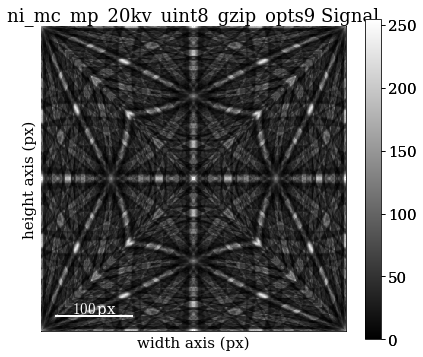

In [5]:
mp.plot()

The Nickel phase information, specifically the crystal symmetry, asymmetric atom
positions, and the crystal lattice, is easily available

In [6]:
ni = mp.phase
ni

<name: ni. space group: Fm-3m. point group: m-3m. proper point group: 432. color: tab:blue>

In [7]:
ni.structure  # Element, x, y, z, site occupation

[28   0.000000 0.000000 0.000000 1.0000]

In [8]:
ni.structure.lattice  # nm

Lattice(a=0.35236, b=0.35236, c=0.35236, alpha=90, beta=90, gamma=90)

Let's get the crystal (unit cell) orientations to populate our dictionary with,
by sampling the Rodrigues Fundamental Zone of the proper point group *432* with
a 5$^{\circ}$ characteristic distance between orientations (we can either pass
in the proper point group, or the space group, which is a subgroup of the proper
point group)

In [9]:
r = sampling.get_sample_fundamental(
    resolution=5, space_group=ni.space_group.number
)
r

Rotation (7467,)
[[ 1.     -0.     -0.     -0.    ]
 [ 0.986  -0.1667 -0.     -0.    ]
 [ 0.9718 -0.2357 -0.     -0.    ]
 ...
 [ 0.9538 -0.2887 -0.      0.0834]
 [ 0.9392 -0.3333 -0.      0.0822]
 [ 0.9244 -0.3727 -0.      0.0809]]

This returned 7 467 crystal orientations.

<div class="alert alert-info">

Note

A characteristic distance of 5$^{\circ}$ gives a course sampling of orientation
space, a much shorter distance should be used for real experimental work.

</div>

Now that we have our master pattern and crystal orientations, we need to
describe the EBSD detector's position with respect to the sample (interaction
volume), so that projection parts of the master pattern onto our detector yields
simulated patterns resembling our experimental ones

In [10]:
detector = kp.detectors.EBSDDetector(
    shape=s.axes_manager.signal_shape[::-1],
    pc=[0.421, 0.7794, 0.5049],
    sample_tilt=70,
    convention="tsl",
)
detector

EBSDDetector (60, 60), px_size 1 um, binning 1, tilt 0, pc (0.421, 0.221, 0.505)

Let's double check the projection/pattern center position on the detector

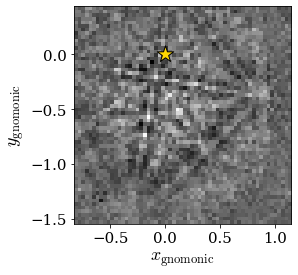

In [11]:
detector.plot(coordinates="gnomonic", pattern=s.inav[0, 0].data)

Finally, we're ready to generate our dictionary of simulated patterns by
projecting parts of the master pattern onto our detector

In [16]:
sim = mp.get_patterns(
    rotations=r,
    detector=detector,
    energy=20,
    dtype_out=s.data.dtype,
    compute=True
)
sim

<EBSD, title: , dimensions: (7467|60, 60)>

Let's inspect the three first of the 7 467 simulated patterns

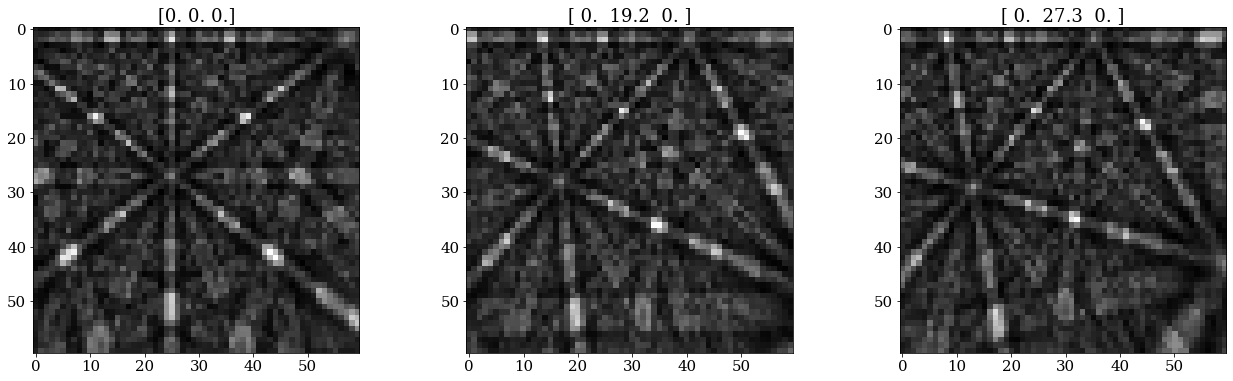

In [17]:
#sim.plot()  # Plot the patterns with a navigator for easy inspection
fig, ax = plt.subplots(ncols=3, figsize=(22, 6))
for i in range(3):
    ax[i].imshow(sim.inav[i].data, cmap="gray")
    euler = np.rad2deg(sim.xmap[i].rotations.to_euler())[0]  # phi1, Phi, phi2
    ax[i].set_title(np.array_str(euler, precision=1))

Finally, let's match the 7 467 simulated patterns to our nine experimental
patterns using zero-mean normalized cross correlation (NCC), which is the
default, and keep the 10 best matching orientations. To control the memory use
of this matching, we slice our simulated pattern data set into 10 slices. The
results is returned as a crystal map

In [18]:
xmap = s.match_patterns(sim, n_slices=10, keep_n=10)

Matching ni patterns: 100%|██████████| 10/10 [00:00<00:00, 14.05slice/s, mem=42.3%]


Get a map of the NCC coefficients of the best matching patterns

In [19]:
ncc = xmap.get_map_data(xmap.scores[:, 0])
ncc

array([[0.261, 0.268, 0.302],
       [0.259, 0.268, 0.308],
       [0.255, 0.276, 0.299]])

Get the best matching simulated patterns from the dictionary

In [20]:
best_patterns = sim.data[xmap.simulation_indices[:, 0]].reshape(s.data.shape)
#s_sim = kp.signals.EBSD(best_patterns.compute())
s_sim = kp.signals.EBSD(best_patterns)
s_sim

<EBSD, title: , dimensions: (3, 3|60, 60)>

Inspect the experimental and best matching simulated patterns in a best scores
map (NCC coefficients)

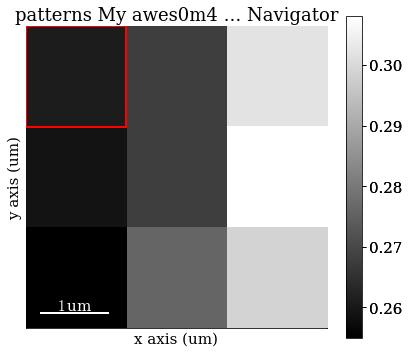

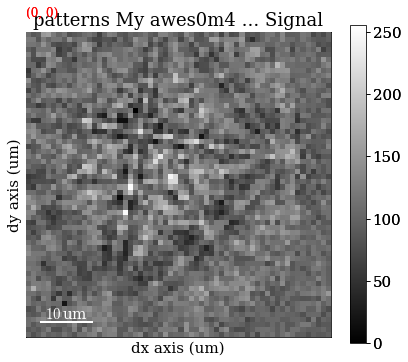

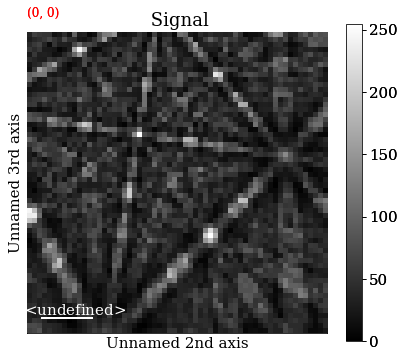

In [21]:
hs.plot.plot_signals([s, s_sim], navigator=hs.signals.Signal2D(ncc))